In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.models as models
import random as random
import copy

In [2]:
n_labels = 10
unrolled_step = 0
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"
print(device)

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

def get_mnist(location="./", batch_size=64):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms
    
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    
    img_transform = lambda x: compose(x).view(-1)
    

    mnist_train = MNIST(location, train=True, download=True,transform=img_transform, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,transform=img_transform, target_transform=onehot(n_labels))

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
    
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size)

    return labelled, validation

cuda:0


In [3]:
labelled, valid = get_mnist()

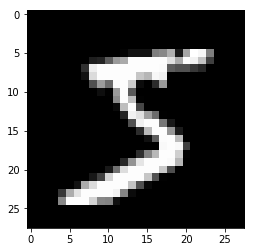

In [4]:
plt.imshow(next(iter(labelled))[0][0].view(28,28), cmap='gray')

In [5]:
class Generator(nn.Module):
    def __init__(self, in_dim=110, out_dim=784, d=128):
        super().__init__()
#         self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=256),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Linear(in_features=256, out_features=512),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Linear(in_features=512, out_features=1024),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Linear(in_features=1024, out_features=out_dim),
#                                  nn.Tanh())

        self.net = nn.Sequential(nn.ConvTranspose2d(in_channels=100, out_channels=d*4, kernel_size=4, stride=1, padding=0),
                         nn.BatchNorm2d(d*4),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=d*4, out_channels=d*2, kernel_size=4, stride=2, padding=1),
                         nn.BatchNorm2d(d*2),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=d*2, out_channels=d, kernel_size=3, stride=2, padding=1),
                         nn.BatchNorm2d(d),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=d, out_channels=1, kernel_size=2, stride=2, padding=1),
                         nn.Tanh())
    
        self.linear = nn.Linear(in_features=in_dim, out_features=100)
        
    def forward(self,x):
        x = self.linear(x).view(-1,100,1,1)
        return self.net(x)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_dim=794, d=128):
        super().__init__()
#         self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=1024),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(in_features=1024, out_features=512),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(in_features=512, out_features=256),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(in_features=256, out_features=1),
#                                  nn.Sigmoid())
        self.net = nn.Sequential(nn.Conv2d(1, d, 2, 2, 1),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(d, d*2, 3, 2, 1),
                                 nn.BatchNorm2d(d*2),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(d*2, d*4, 4, 2, 1),
                                 nn.BatchNorm2d(d*4),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(d*4, 1, 4, 1, 0),
                                 nn.Sigmoid())
        self.linear = nn.Linear(in_features=in_dim, out_features=784)
        
    def forward(self,x):
        x = self.linear(x).view(-1,1,28,28)
        return self.net(x)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()

In [7]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

generator = Generator()
discriminator = Discriminator()

generator.weight_init(mean=0.0, std=0.02)
discriminator.weight_init(mean=0.0, std=0.02)

generator = generator.to(device)
discriminator = discriminator.to(device)
# classifier = models.resnet18()

In [8]:
x = torch.rand(100).to(device)
label = onehot(10)(random.randint(0,9)).to(device)
x = torch.cat((x, label))

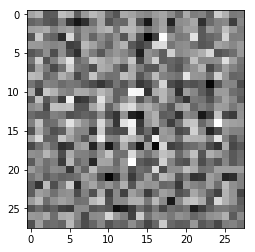

In [9]:
plt.imshow(generator(x).view(28,28).cpu().detach(), cmap='gray')

In [10]:
discriminator(torch.cat((generator(x).view(-1), label)))

tensor([[[[0.5837]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [11]:
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
def to_variable(x):
    '''
    convert a tensor to a variable
    with gradient tracking
    '''
    x = x.to(device)
    return Variable(x)

In [13]:
def label_gen(size, real):
    label_smoothing = 1
    if real:
        return to_variable(label_smoothing * torch.ones(size, 1))
    else:
        return to_variable(torch.zeros(size, 1))

In [14]:
def d_loop(batch_size, batch_data):
    fake_labels = label_gen(size = batch_size, real=False)
    true_labels = label_gen(size = batch_size, real=True)
    
    # Train discriminator on real data 
    discriminator.zero_grad()
    batch_images = to_variable(batch_data[0])
    classes_real = to_variable(batch_data[1])

    outputs_real = discriminator(torch.cat((batch_images, classes_real), -1))

    lossD_real = criterion(outputs_real, true_labels)

    lossD_real.backward()


    # Train discriminator on fake data 

    noise = to_variable(torch.randn(batch_size, 100))
    classes_fake = to_variable(torch.stack(list
                                           (map(lambda x: onehot(10)(x), 
                                                list(np.random.randint(10, size=batch_size))))))
    
    fake_images = generator(torch.cat((noise, classes_fake), -1)).view(batch_size, -1)
    outputs_fake_d = discriminator(torch.cat((fake_images.detach(), classes_fake), -1))
    lossD_fake = criterion(outputs_fake_d, fake_labels)


    lossD_fake.backward()


    lossD = lossD_fake + lossD_real

    optimizerD.step()
    
    return lossD


In [15]:
def d_loop_unrolled(batch_size, batch_data, noise, classes_fake):
    fake_labels = label_gen(size = batch_size, real=False)
    true_labels = label_gen(size = batch_size, real=True)
    
    # Train discriminator on real data 
    discriminator.zero_grad()
    batch_images = to_variable(batch_data[0])
    classes_real = to_variable(batch_data[1])

    outputs_real = discriminator(torch.cat((batch_images, classes_real), -1))

    lossD_real = criterion(outputs_real, true_labels)

    lossD_real.backward()


    # Train discriminator on fake data 
    
    with torch.no_grad():
        fake_images = generator(torch.cat((noise, classes_fake), -1)).view(batch_size, -1)
    outputs_fake_d = discriminator(torch.cat((fake_images.detach(), classes_fake), -1))
    lossD_fake = criterion(outputs_fake_d, fake_labels)


    lossD_fake.backward(create_graph=True)


    lossD = lossD_fake + lossD_real

    optimizerD.step()
    
    return lossD

In [16]:
def g_loop(batch_size, batch_data): 
    
    true_labels = label_gen(size = batch_size, real=True)  
    fake_labels = label_gen(size = batch_size, real=False)  
    noise = to_variable(torch.randn(batch_size, 100))
    classes_fake = to_variable(torch.stack(list
                                           (map(lambda x: onehot(10)(x), 
                                                list(np.random.randint(10, size=batch_size))))))
    # Train generator
    generator.zero_grad()
    
    #unrolled loop
    if unrolled_step>0:
        backup = copy.deepcopy(discriminator)
        for step in range(unrolled_step):
            d_loop_unrolled(batch_size, batch_data, noise, classes_fake)
    
    fake_images = generator(torch.cat((noise, classes_fake), -1)).view(batch_size, -1)
    outputs_fake_g = discriminator(torch.cat((fake_images, classes_fake), -1))
    lossG =  criterion(outputs_fake_g, true_labels)

    lossG.backward()

    optimizerG.step()
    
    # reset backup discriminator
    if unrolled_step>0:
        discriminator.load(backup)
        del backup
    
    return lossG

In [17]:
criterion = nn.BCELoss()
NUM_EPOCH = 100

def train():
    loss_g, loss_d = [], []
    for epoch in range(NUM_EPOCH):
        
        for idx, batch_data in enumerate(labelled):
            
            
            batch_size = batch_data[0].shape[0]
            
            lossD = d_loop(batch_size, batch_data)
            
            lossG = g_loop(batch_size, batch_data)
            
            loss_d.append(lossD.item())
            loss_g.append(lossG.item())
#             print(lossG)
            
        print("Epoch: ", epoch, ", Gloss: ", loss_g[-1], ", Dloss: ", loss_d[-1])
            

In [18]:
train()

/home/pierre/.local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/pierre/.local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:  0 , Gloss:  4.658504486083984 , Dloss:  0.8457977771759033
Epoch:  1 , Gloss:  3.6184074878692627 , Dloss:  1.3090347051620483
Epoch:  2 , Gloss:  1.2272381782531738 , Dloss:  1.024185299873352
Epoch:  3 , Gloss:  0.9760834574699402 , Dloss:  1.3773785829544067
Epoch:  4 , Gloss:  1.19696044921875 , Dloss:  1.1480393409729004
Epoch:  5 , Gloss:  0.715816855430603 , Dloss:  1.3016151189804077
Epoch:  6 , Gloss:  0.768888533115387 , Dloss:  1.3907212018966675
Epoch:  7 , Gloss:  0.7408793568611145 , Dloss:  1.3751299381256104
Epoch:  8 , Gloss:  0.8155004978179932 , Dloss:  1.4455530643463135
Epoch:  9 , Gloss:  0.7287998795509338 , Dloss:  1.3484370708465576
Epoch:  10 , Gloss:  0.692380428314209 , Dloss:  1.4468839168548584
Epoch:  11 , Gloss:  0.7848227620124817 , Dloss:  1.3017585277557373
Epoch:  12 , Gloss:  0.7823008298873901 , Dloss:  1.4974133968353271
Epoch:  13 , Gloss:  0.7759528756141663 , Dloss:  1.3414747714996338
Epoch:  14 , Gloss:  0.6671223640441895 , Dloss:  1

KeyboardInterrupt: 

In [19]:
x = torch.randn(100,100).to(device)
label = torch.stack(list(map(lambda x: onehot(10)(x),[int(i/10) for i in range(100)]))).to(device)
x = torch.cat((x, label),-1)
x.shape

torch.Size([100, 110])

In [20]:
generator(x).shape

torch.Size([100, 1, 28, 28])

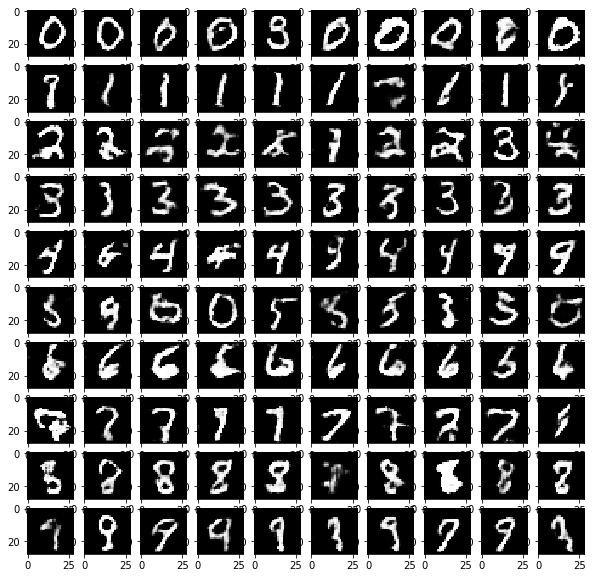

In [21]:
plt.figure(figsize=(10,10))

for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(generator(x)[10*i+j].view(28,28).cpu().detach(), cmap='gray')

In [22]:
#Explore latent space of 9

x = torch.randn(10,10,100).to(device)
x[:,0,0]= torch.Tensor(np.linspace(-0.1,0.1,10))
x[:,0,1]= torch.Tensor(np.linspace(-0.1,0.1,10))
label = torch.stack([onehot(10)(9) for i in range(100)]).to(device)
y = torch.cat((x.view(100,100), label),-1)
y

tensor([[-0.1000, -0.1000, -1.5236,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.5947, -1.3532, -1.7969,  ...,  0.0000,  0.0000,  1.0000],
        [-1.0518, -0.6099, -0.9683,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.5333, -0.2152,  1.4901,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0727, -1.0743,  0.4920,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.1190,  1.5395,  0.7921,  ...,  0.0000,  0.0000,  1.0000]],
       device='cuda:0')

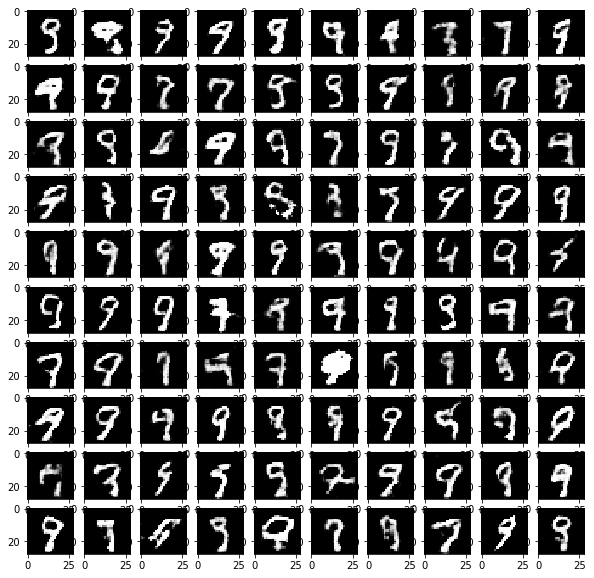

In [23]:
plt.figure(figsize=(10,10))

for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(generator(y)[10*i+j].view(28,28).cpu().detach(), cmap='gray')